In [608]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import sparse
import random
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import plotly.express as px
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS 
import re
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
from nltk.corpus import stopwords
import string
from scipy.sparse import coo_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer


import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('tripadvisor.csv')
df.head(3)

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   

                                             address             name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...            Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...   Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...  San Churro Cafe   

  online_order book_table   rate  votes                           phone  \
0          Yes        Yes  4.1/5    775  080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5    787                    080 41714161   
2          Yes         No  3.8/5    918                  +91 9663487993   

       location            rest_type  \
0  Banashankari        Casual Dining   
1  Banashankari        Casual Dining   
2  Banashankari  Cafe, Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   

                         cuisines approx_cost(for two people)  \
0  North Indian, Mughlai, Chinese                         800   
1     Chinese, North Indian, Thai                         800   
2          Cafe, Mexican, Italian                         800   

                                        reviews_list menu_item  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []   

  listed_in(type) listed_in(city)  
0          Buffet    Banashankari  
1          Buffet    Banashankari  
2          Buffet    Banashankari

Адрес сайта и номер телефона, вероятно не будут оказывать на модель особого влияние, исключим их. А также удалим дубликаты.

In [6]:
restaurants = df.drop(['url','phone'], axis=1)
restaurants = restaurants.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type','listed_in(city)':'city'})
restaurants.drop_duplicates(inplace=True)
restaurants.head()

address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes      location            rest_type  \
0          Yes        Yes  4.1/5    775  Banashankari        Casual Dining   
1          Yes         No  4.1/5    787  Banashankari        Casual Dining   
2          Yes         No  3.8/5    918  Banashankari  Cafe, Casual Dining   
3           No         No  3.7/5     88  Banashankari          Quick Bites   
4           No         No  3.8/5    166  Basavanagudi        Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   
4                                Panipuri, Gol Gappe   

                         cuisines cost  \
0  North Indian, Mughlai, Chinese  800   
1     Chinese, North Indian, Thai  800   
2          Cafe, Mexican, Italian  800   
3      South Indian, North Indian  300   
4        North Indian, Rajasthani  600   

                                        reviews_list menu_item    type  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []  Buffet   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []  Buffet   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []  Buffet   
3  [('Rated 4.0', "RATED\n  Great food and proper...        []  Buffet   
4  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []  Buffet   

           city  
0  Banashankari  
1  Banashankari  
2  Banashankari  
3  Banashankari  
4  Banashankari

In [7]:
print("Процент нулевых значений:")
(restaurants.isnull().sum()*100/restaurants.index.size).round(2)

Процент нулевых значений:


address          0.00
name             0.00
online_order     0.00
book_table       0.00
rate            15.03
votes            0.00
location         0.04
rest_type        0.44
dish_liked      54.28
cuisines         0.09
cost             0.67
reviews_list     0.00
menu_item        0.00
type             0.00
city             0.00
dtype: float64

Удалим пропущенные значения в столбцах Location, rest_type, cuisines, approx_cost. Поскольку их очень мало относительно всего датасета.

In [8]:
restaurants.dropna(subset=['location', 'rest_type', 'cuisines', 'cost'],inplace=True)

print("Процент нулевых значений:")
(restaurants.isnull().sum()*100/restaurants.index.size).round(2)

Процент нулевых значений:


address          0.00
name             0.00
online_order     0.00
book_table       0.00
rate            14.88
votes            0.00
location         0.00
rest_type        0.00
dish_liked      54.17
cuisines         0.00
cost             0.00
reviews_list     0.00
menu_item        0.00
type             0.00
city             0.00
dtype: float64

Преобразуем cost в числовой формат:

In [9]:
restaurants['cost'] = restaurants['cost'].astype(str) 
restaurants['cost'] = restaurants['cost'].apply(lambda x: x.replace(',','')) 
restaurants['cost'] = restaurants['cost'].astype(int) 
restaurants['cost'].unique()

array([ 800,  300,  600,  700,  550,  500,  450,  650,  400,  900,  200,
        750,  150,  850,  100, 1200,  350,  250,  950, 1000, 1500, 1300,
        199,   80, 1100,  160, 1600,  230,  130,   50,  190, 1700, 1400,
        180, 1350, 2200, 2000, 1800, 1900,  330, 2500, 2100, 3000, 2800,
       3400,   40, 1250, 3500, 4000, 2400, 2600,  120, 1450,  469,   70,
       3200,   60,  560,  240,  360, 6000, 1050, 2300, 4100, 5000, 3700,
       1650, 2700, 4500,  140])

Заменим в rate все пропущенные значения и NEW на -, уберем /5 в значениях.

In [10]:
restaurants['rate'] = restaurants['rate'].fillna('-')
restaurants['rate'] = restaurants['rate'].replace('NEW','-')
restaurants['rate'] = restaurants['rate'].apply(lambda x: x.replace('/5', '') if type(x) == np.str else x)
restaurants['rate'].unique()

/var/folders/kp/blh_kxk96fg0f92wtxzv02h80000gn/T/ipykernel_763/1102427815.py:3: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  restaurants['rate'] = restaurants['rate'].apply(lambda x: x.replace('/5', '') if type(x) == np.str else x)


array(['4.1', '3.8', '3.7', '3.6', '4.6', '4.0', '4.2', '3.9', '3.1',
       '3.0', '3.2', '3.3', '2.8', '4.4', '4.3', '-', '2.9', '3.5', '2.6',
       '3.8 ', '3.4', '4.5', '2.5', '2.7', '4.7', '2.4', '2.2', '2.3',
       '3.4 ', '3.6 ', '4.8', '3.9 ', '4.2 ', '4.0 ', '4.1 ', '3.7 ',
       '3.1 ', '2.9 ', '3.3 ', '2.8 ', '3.5 ', '2.7 ', '2.5 ', '3.2 ',
       '2.6 ', '4.5 ', '4.3 ', '4.4 ', '4.9', '2.1', '2.0', '1.8', '4.6 ',
       '4.9 ', '3.0 ', '4.8 ', '2.3 ', '4.7 ', '2.4 ', '2.1 ', '2.2 ',
       '2.0 ', '1.8 '], dtype=object)

In [11]:
restaurants = restaurants.reset_index(drop=True)

В столбце rate достаточно много пропущенных значений, чтобы не заменять их рандомно, посчитаем средний rate из массива отзывов. Затем заменим попущенные значения (если на них есть массив отзывов).

In [12]:
def print_rate(x):
    l = []
    if x != '[]' :
        x = eval(x)
        for i in range(len(x)):
            if (x)[i][0] is None:
                pass
            else:
                z = float((x)[i][0].replace('Rated ',''))
                l.append(z)
        return round(mean(l),1)
    else: 
        return '-'

restaurants['reviews_rate'] = restaurants['reviews_list'].apply(print_rate)

In [13]:
restaurants.head(3)

address             name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...            Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...   Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...  San Churro Cafe   

  online_order book_table rate  votes      location            rest_type  \
0          Yes        Yes  4.1    775  Banashankari        Casual Dining   
1          Yes         No  4.1    787  Banashankari        Casual Dining   
2          Yes         No  3.8    918  Banashankari  Cafe, Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   

                         cuisines  cost  \
0  North Indian, Mughlai, Chinese   800   
1     Chinese, North Indian, Thai   800   
2          Cafe, Mexican, Italian   800   

                                        reviews_list menu_item    type  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []  Buffet   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []  Buffet   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []  Buffet   

           city reviews_rate  
0  Banashankari          4.1  
1  Banashankari          3.6  
2  Banashankari          3.1

In [14]:
print("Количество пропущенных значений до момента замены: ",restaurants[restaurants.rate == '-'].shape[0])

Количество пропущенных значений до момента замены:  9869


In [15]:
restaurants['rate'] = np.where(restaurants['rate'] == '-', restaurants['reviews_rate'], restaurants['rate'])
print("Количество пропущенных значений после момента замены: ",restaurants[restaurants.rate == '-'].shape[0])
print("Процент этих значений в датасете: ", round((restaurants[restaurants.rate == '-'].shape[0] / restaurants.shape[0])*100,2))

Количество пропущенных значений после момента замены:  6368
Процент этих значений в датасете:  12.46


Для удобства анализа данных заменим все "-" нулями:

In [16]:
restaurants['rate'] = restaurants['rate'].replace('-','0.0')
restaurants['rate'] = restaurants['rate'].astype(float)

Удалим из рейтинга только те строки, где рейтинг 0, а количество голосов отлично от 0 (т.е. вероятнее всего, что наблюдения просто были пропущены при формировании датасета). Процент этих наблюдений очень мал относительно всего датасета. 

In [17]:
restaurants = restaurants.drop(restaurants[(restaurants['votes'] != 0) & (restaurants['rate'] == 0)].index)


In [18]:
restaurants = restaurants.reset_index(drop=True)

### EDA

In [19]:
res = restaurants.drop('reviews_rate',axis=1)
res.head(3)

address             name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...            Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...   Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...  San Churro Cafe   

  online_order book_table  rate  votes      location            rest_type  \
0          Yes        Yes   4.1    775  Banashankari        Casual Dining   
1          Yes         No   4.1    787  Banashankari        Casual Dining   
2          Yes         No   3.8    918  Banashankari  Cafe, Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   

                         cuisines  cost  \
0  North Indian, Mughlai, Chinese   800   
1     Chinese, North Indian, Thai   800   
2          Cafe, Mexican, Italian   800   

                                        reviews_list menu_item    type  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []  Buffet   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []  Buffet   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []  Buffet   

           city  
0  Banashankari  
1  Banashankari  
2  Banashankari

In [19]:
res[['rate','votes','cost']].describe()

rate         votes          cost
count  51090.000000  51090.000000  51090.000000
mean       3.233766    285.120963    556.112253
std        1.331006    806.887056    439.637632
min        0.000000      0.000000     40.000000
25%        3.200000      7.000000    300.000000
50%        3.700000     41.000000    400.000000
75%        4.000000    200.000000    700.000000
max        5.000000  16832.000000   6000.000000

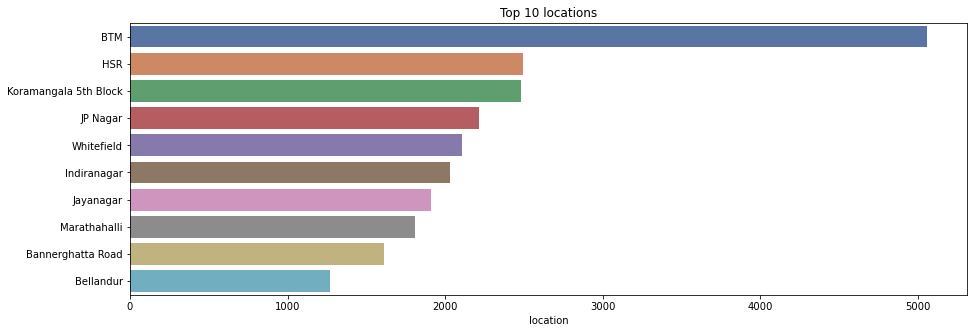

In [20]:
plt.figure(figsize=(15,5))
loc=res['location'].value_counts()[0:10]
sns.barplot(x=loc,y=loc.index,palette='deep')
plt.title("Top 10 locations")
plt.show()

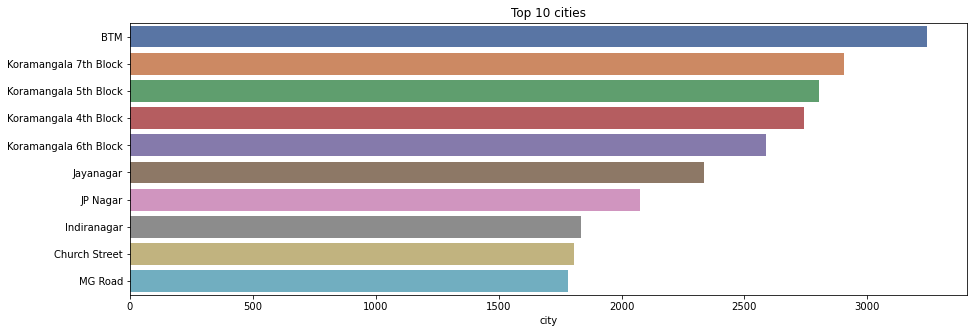

In [21]:
plt.figure(figsize=(15,5))
loc=res['city'].value_counts()[0:10]
sns.barplot(x=loc,y=loc.index,palette='deep')
plt.title("Top 10 cities")
plt.show()

Для того, чтобы было более явно видно, зависит ли количество заведений от месторасположения (района, может быть центра города), построим heatmap с визуализацией заведений на карте.

In [383]:
locations=pd.DataFrame({"Name":res['location'].unique()})
locations['Name']=locations['Name']
lat_lon=[]
geolocator=Nominatim(user_agent="app")
for location in locations['Name']:
    location = geolocator.geocode(location, timeout= 20)
    if location is None:
        lat_lon.append(np.nan)
    else:    
        geo=(location.latitude,location.longitude)
        lat_lon.append(geo)


locations['geo_loc']=lat_lon

In [385]:
rest_count= pd.DataFrame(res['location'].value_counts().reset_index())
rest_count.columns= ['Name', 'count']
rest_count=rest_count.merge(locations, on = "Name", how = "left" ).dropna()
rest_count.head()

Name  count                             geo_loc
0                    BTM   5058  (45.95485055, -112.49659530324134)
1                    HSR   2495                (18.1475, 41.538889)
2  Koramangala 5th Block   2480            (12.9348429, 77.6189768)
3               JP Nagar   2214            (12.2655944, 76.6465404)
4             Whitefield   2107            (53.5533682, -2.2969019)

In [392]:
maps = folium.Map()

lat , lon= zip(*np.array(rest_count['geo_loc']))
rest_count['lat']= lat
rest_count['lon']= lon

HeatMap(rest_count[['lat', 'lon', 'count']].values.tolist()).add_to(maps)
maps

Видно, что большинство заведений из датасета находятся в Индии, а именно в городе Бангалоре, где большинство заведений расположены в 3х районах. 

<AxesSubplot:xlabel='rest_type'>

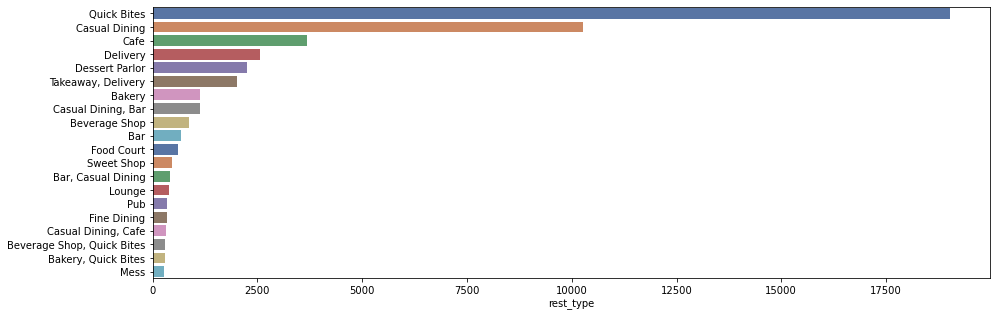

In [22]:
plt.figure(figsize=(15,5))
loc=res['rest_type'].value_counts()[0:20]
sns.barplot(x=loc,y=loc.index,palette='deep')

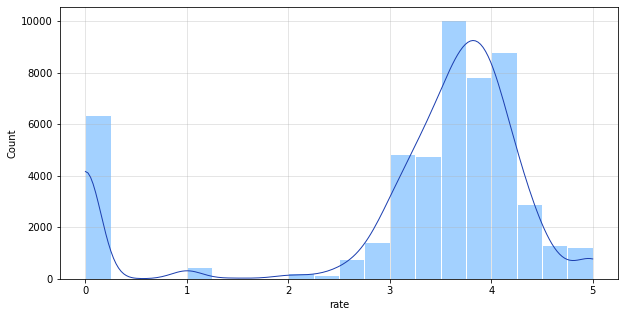

In [23]:
plt.figure(figsize=(10,5))
plt.grid(True, alpha = 0.4)
ax = sns.histplot(res['rate'],bins=20,alpha=0.6,color='#66b3ff',kde=True, line_kws={'linewidth':1},edgecolor='white')
ax.lines[0].set_color('#1C3FB0')
plt.show()

Видно, что большинство ресторанов имеют рейтинг 3,6-3,8. При этом, около 6000 заведений вообще не имеют рейтинга. 

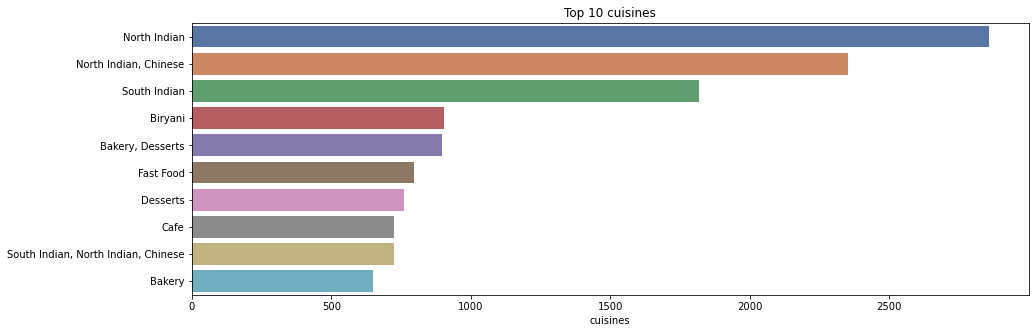

In [24]:
plt.figure(figsize=(15,5))
loc=res['cuisines'].value_counts()[0:10]
sns.barplot(x=loc,y=loc.index,palette='deep')
plt.title("Top 10 cuisines")
plt.show()

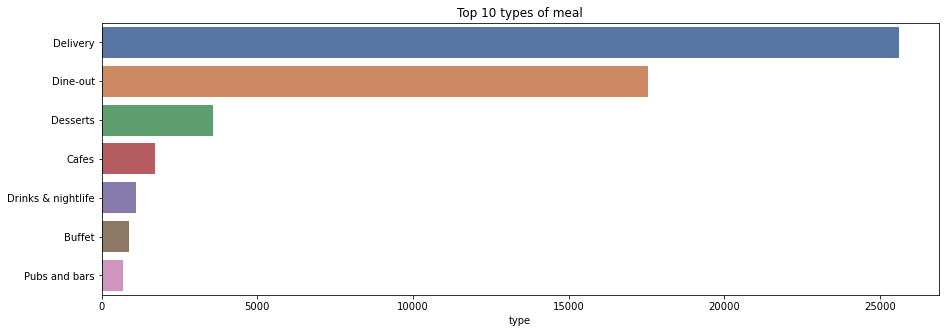

In [25]:
plt.figure(figsize=(15,5))
loc=res['type'].value_counts()[0:10]
sns.barplot(x=loc,y=loc.index,palette='deep')
plt.title("Top 10 types of meal")
plt.show()

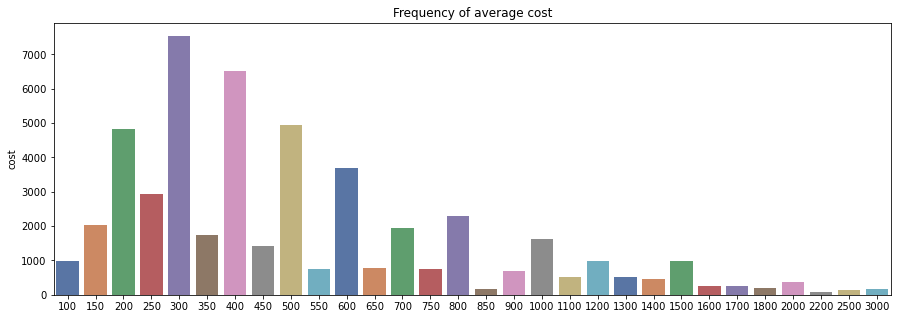

In [27]:
plt.figure(figsize=(15,5))
loc=res['cost'].value_counts()[0:30]
sns.barplot(x=loc.index,y=loc,palette='deep')
plt.title('Frequency of average cost')
plt.show()

Большинство заведений имеют средний чек 200-500.

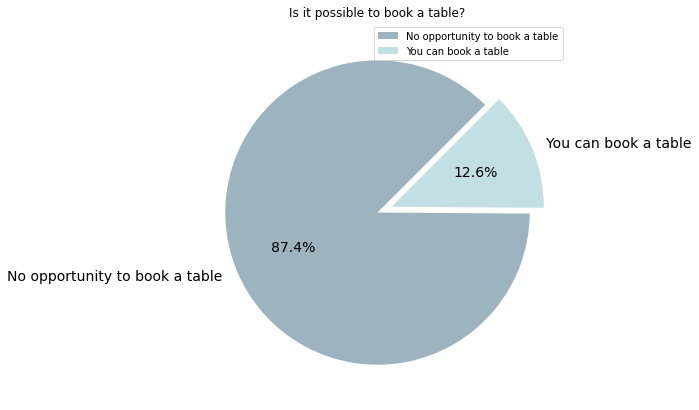

In [28]:
plt.figure(figsize=(7,7))
plt.pie(res['book_table'].value_counts(),
        labels = ["No opportunity to book a table",'You can book a table'],
        autopct='%1.1f%%',
        explode=(0,0.1),
        startangle=45,
        colors=['#9db4c0','#c2dfe3'],
        textprops={'fontsize': 14})
plt.title("Is it possible to book a table?")
plt.legend()
plt.show() 

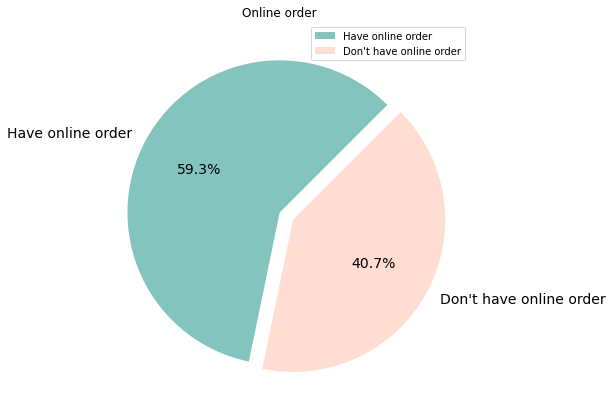

In [29]:
plt.figure(figsize=(7,7))
plt.pie(res['online_order'].value_counts(),
        labels = ['Have online order',"Don't have online order"],
        autopct='%1.1f%%',
        explode=(0,0.1),
        startangle=45,
        colors=['#83c5be','#ffddd2'],
        textprops={'fontsize': 14})
plt.title("Online order")
plt.legend()
plt.show()

Посмотрим на топ-15 районов в зависимости от наибольшего общего числа голосов и наибольшего среднего рейтинга:

In [675]:
location_rate_votes = pd.DataFrame(res.groupby('location')['rate', 'votes'].agg({'rate':np.mean,'votes':np.sum}).sort_values(by = ['votes','rate'], ascending = [False,False]))

location_rate_votes[:15]



rate    votes
location                                
Koramangala 5th Block  3.872460  2214816
Indiranagar            3.580374  1172729
Koramangala 4th Block  3.450836   685156
Church Street          3.844815   594979
JP Nagar               3.137805   586374
BTM                    3.039798   573655
Lavelle Road           3.932438   503143
HSR                    3.210982   498772
Koramangala 7th Block  3.659439   495289
Jayanagar              3.459215   486576
Whitefield             3.012577   465734
Koramangala 6th Block  3.695830   463503
Marathahalli           3.043363   440456
Brigade Road           3.425658   429620
MG Road                3.515884   428489

Есть ли какие-то сети ресторанов, которые имеют больше одного ресторана в данной области: 

Text(0.5, 0, 'Number of restaurants')

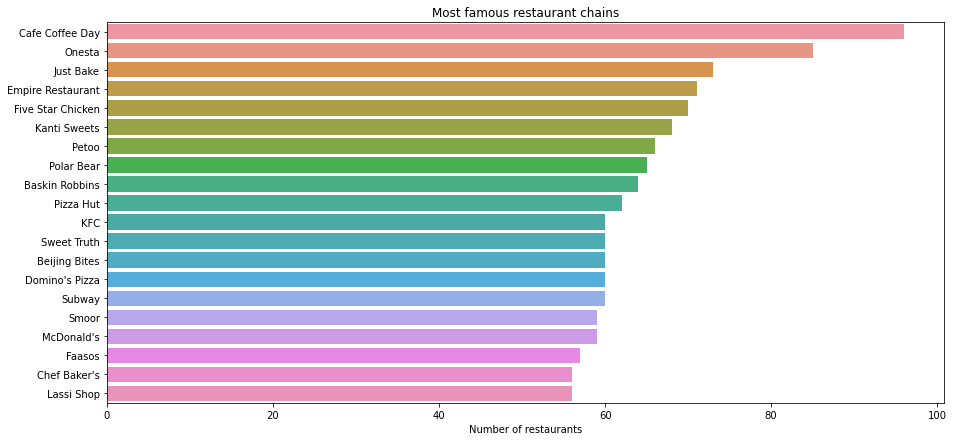

In [23]:
plt.figure(figsize=(15,7))
chains=res['name'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index)
plt.title("Most famous restaurant chains")
plt.xlabel("Number of restaurants")

Самые популярные заведения, которые имеют наибольший рейтинг, а также наибольшее количество голосов (чтобы можно было доверять рейтингу):

In [676]:
top_rated_votes = pd.DataFrame(res.groupby('name')['rate', 'votes'].max().sort_values(by = 'votes', ascending = False))

top_rated_votes[:15]

rate  votes
name                                    
Byg Brewski Brewing Company   4.9  16832
Toit                          4.7  14956
Truffles                      4.7  14726
AB's - Absolute Barbecues     4.9  12121
The Black Pearl               4.8  10550
Big Pitcher                   4.7   9300
Onesta                        4.6   9085
Arbor Brewing Company         4.5   8419
Empire Restaurant             4.4   8304
Prost Brew Pub                4.5   7871
Church Street Social          4.3   7584
Hoot                          4.2   7330
Barbeque Nation               4.8   7270
Meghana Foods                 4.5   7238
Flechazo                      4.9   7154

Есть ли какая-то зависимость по возможности онлайн-заказа в зависимости от района?

In [33]:
sort_location = pd.pivot_table(pd.DataFrame(res.groupby(['location','online_order'])['name'].count()), values=None, index=['location'], columns=['online_order'], fill_value=0, aggfunc=np.sum)
sort_location



name      
online_order         No   Yes
location                     
BTM                1761  3297
Banashankari        396   505
Banaswadi           302   343
Bannerghatta Road   687   923
Basavanagudi        243   440
...                 ...   ...
West Bangalore        4     2
Whitefield          986  1121
Wilson Garden       112   134
Yelahanka             0     5
Yeshwantpur          26    93

[93 rows x 2 columns]

<AxesSubplot:xlabel='location'>

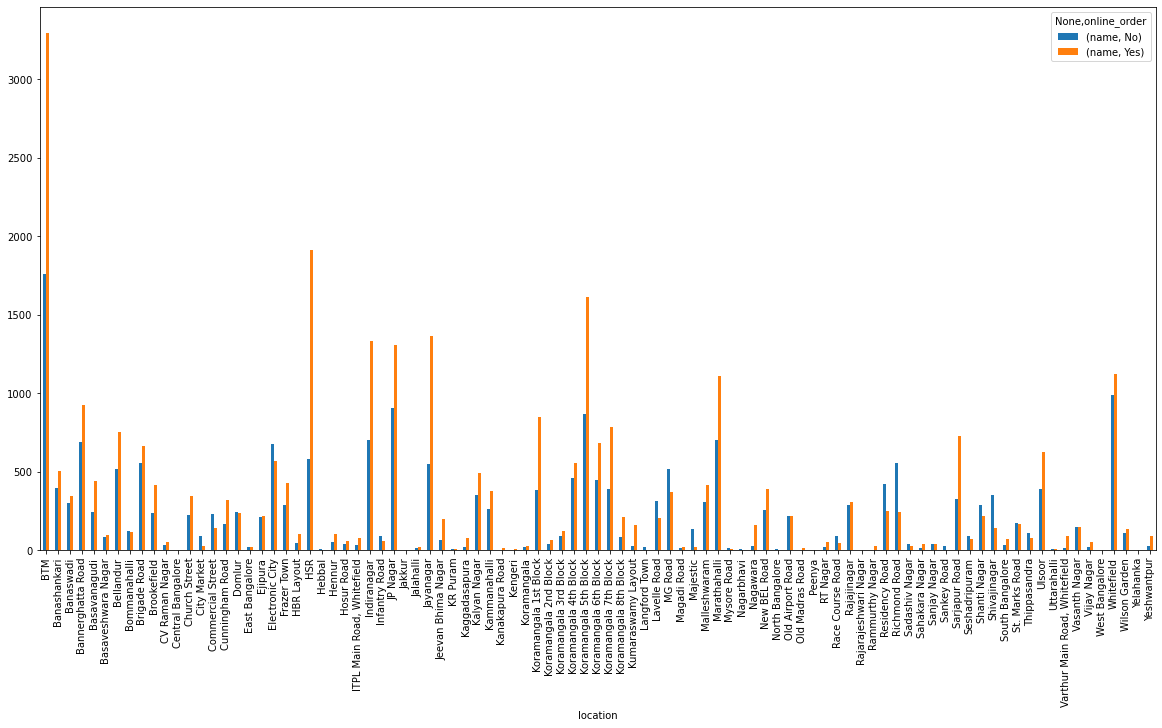

In [34]:
sort_location.plot(kind = 'bar', figsize = (20,10))


Можно сказать, что количество заведений, как с возможностью онлайн-заказа, так и без, примерно одинаково распределено относительно каждого района. Но при этом, в основном, преимущественно представлены заведения с онлайн-заказом. 

Есть ли какая-то зависимость между возможностью заказа стола и районом?

In [35]:
book_location = pd.pivot_table(pd.DataFrame(res.groupby(['location','book_table'])['name'].count()), values=None, index=['location'], columns=['book_table'], fill_value=0, aggfunc=np.sum)
book_location


name     
book_table           No  Yes
location                    
BTM                4891  167
Banashankari        838   63
Banaswadi           637    8
Bannerghatta Road  1511   99
Basavanagudi        667   16
...                 ...  ...
West Bangalore        6    0
Whitefield         1854  253
Wilson Garden       241    5
Yelahanka             5    0
Yeshwantpur         117    2

[93 rows x 2 columns]

<AxesSubplot:xlabel='location'>

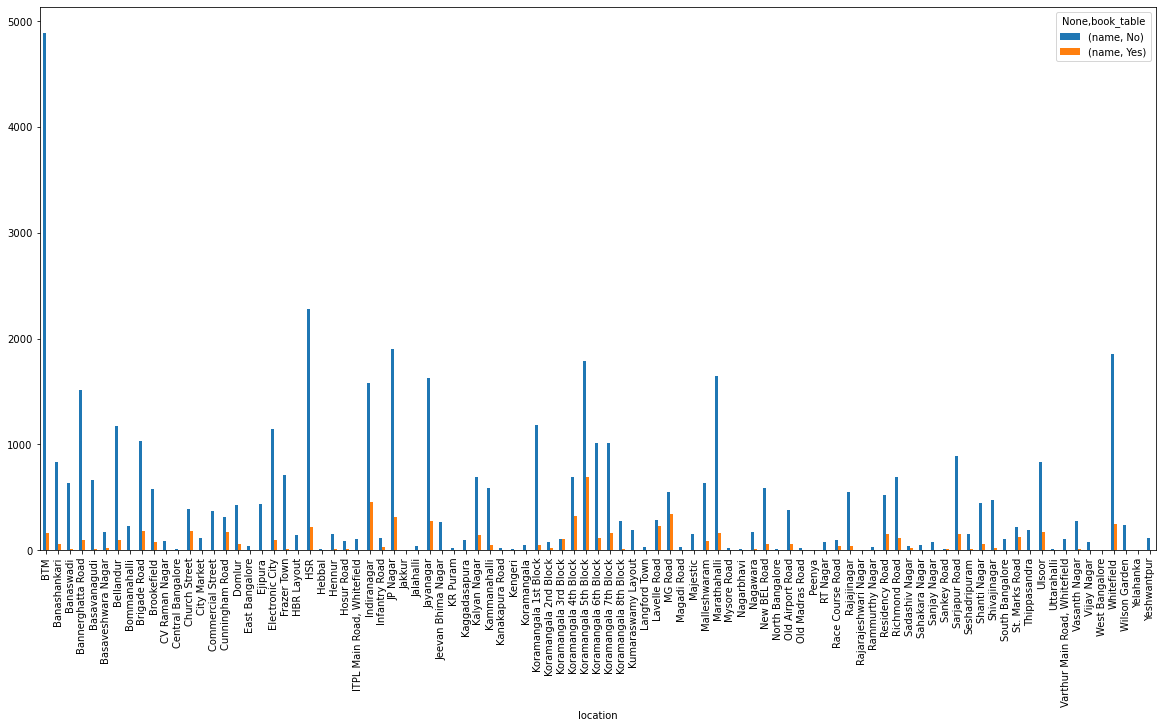

In [36]:
book_location.plot(kind = 'bar', figsize = (20,10))


Распределение возможности/невозможности заказа стола примерно одинаково в зависимости от района. Большинство заведений не имеет возможности бронирования.

А что насчет возможности онлайн-заказа и бронирования стола в зависимости от основных типов ресторанов?

In [37]:
type_online_order = pd.pivot_table(pd.DataFrame(res.groupby(['type','online_order','book_table'])['name'].count()), values=None, index=['type'], columns=['online_order','book_table'], fill_value=0, aggfunc=np.sum)
type_online_order


name                   
online_order          No          Yes      
book_table            No   Yes     No   Yes
type                                       
Buffet               215   302     98   255
Cafes                731    74    695   203
Delivery            6610   254  17063  1690
Desserts            1879    35   1541   104
Dine-out            8113  1253   6983  1213
Drinks & nightlife   380   474     47   190
Pubs and bars        248   250     45   145

<AxesSubplot:xlabel='type'>

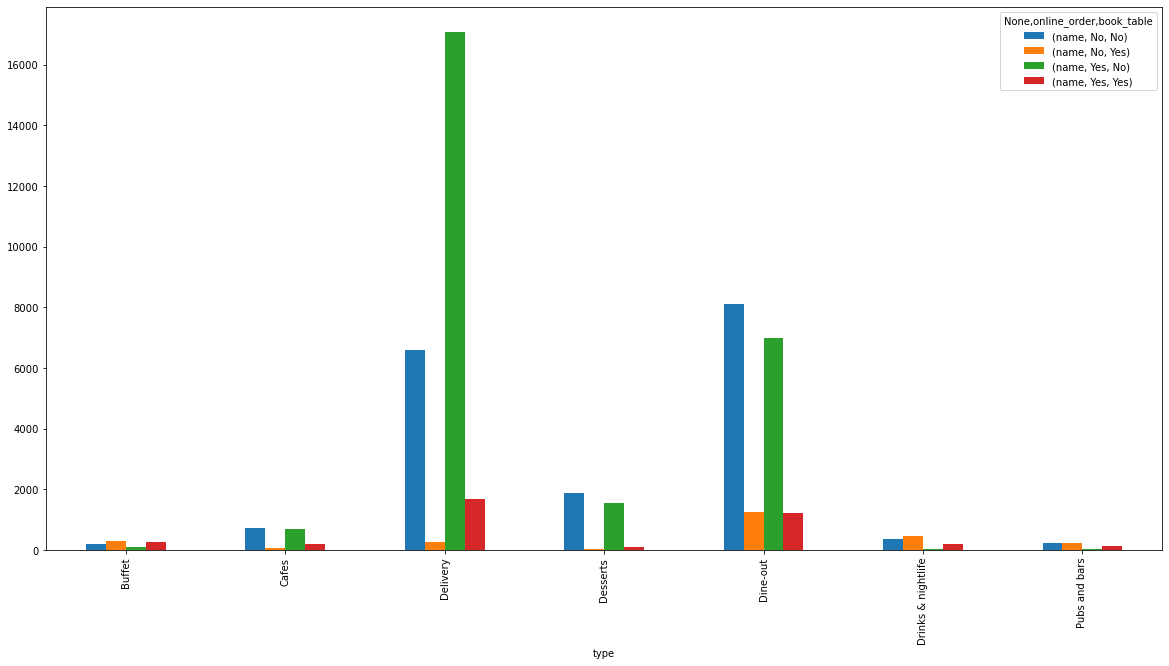

In [38]:
type_online_order.plot(kind = 'bar', figsize = (20,10))

Есть некая зависимость в онлайн-заказе и бронировании в зависимости от типаресторана. Особенно явно видно в категории доставка и dine-out.

In [24]:
fin=res.loc[:,["rate","type","cost"]]
fig = px.histogram(fin, x="rate", color="type")
fig.show()

Если посмотреть на распределение оценок по основным типам рестораном, то можно сделать вывод, что в целом средняя оценка для всех типов одинаковая -  3,6-4. Эта оценка ниже у доставок и dine-out, но при этом эта оценка выше 4 (даже приближается к 4,5) у drinks&nightlife и pubs&bars. 
Также можно увидеть, что количество оценок 0  (то есть или у заведения не было оценок, или заведение новое) наименьшее у категорий drinks&nightlife и buffet. 

Посмотрим на более частые блюда, которые понравились посетителя в заведениях по типам. Может будут какие-то особенные значения?  

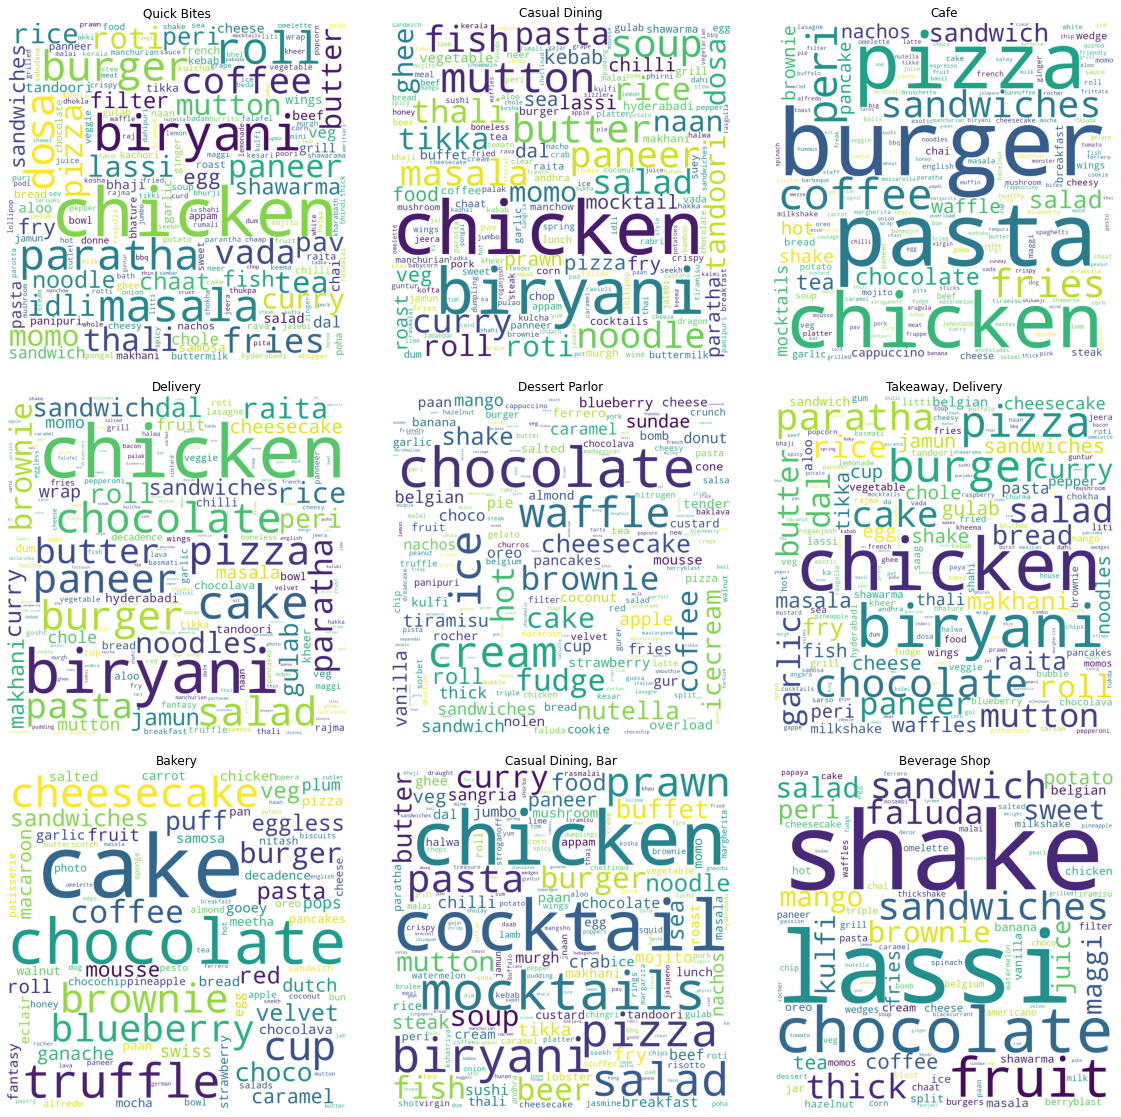

In [40]:
df_new=res.copy()
rest=df_new['rest_type'].value_counts()[:9].index

df_new.dropna(axis='index',subset=['rest_type'],inplace=True)
df_new.dropna(axis='index',subset=['dish_liked'],inplace=True)

def produce_wordcloud(df,rest):
    
    plt.figure(figsize=(20,20))
    for i,restaurant in enumerate(rest):
        plt.subplot(3,3,i+1)
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        dishes=''
        data=df[df['rest_type']==restaurant]
        for word in data['dish_liked']:
            words=word.split()

            for i in range(len(words)): 
                words[i] = words[i].lower() 
            dishes=dishes+ " ".join(words)+" "
        wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,stopwords = stopwords,width=1200, height=1200).generate(dishes)
        plt.imshow(wordcloud)
        plt.title(restaurant)
        plt.axis("off")
        
stopwords = set(STOPWORDS) 
produce_wordcloud(df_new,rest)


В каждом типе заведения примерно одинаковые любимые блюда посетителей (курица, пицца, бирьяни), но в в пекарнях и кондитерских, что вполне логично, любимые блюда - десерты.

In [52]:
type_votes = pd.DataFrame(res.groupby('rest_type')['votes'].sum().sort_values(ascending = False))
type_votes[:10]


votes
rest_type                   
Casual Dining        4537919
Quick Bites          1473590
Cafe                 1438173
Casual Dining, Bar   1222079
Casual Dining, Cafe   527720
Bar, Casual Dining    447532
Lounge                407889
Pub                   403480
Pub, Microbrewery     350648
Cafe, Casual Dining   337753

Может отзывы для основных rest_type будут разные? 

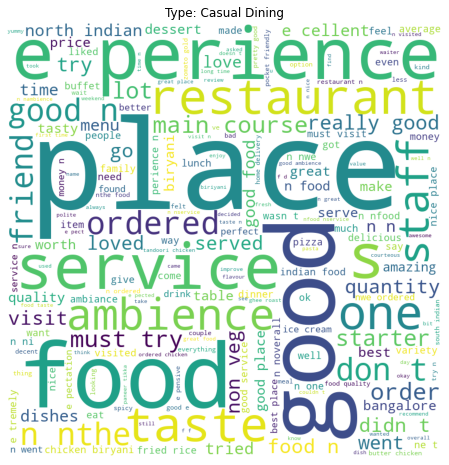

In [53]:
def reviewwords(df,rest_type):
    dataset=df[df['rest_type']==rest_type]
    total_review=' '
    for review in dataset['reviews_list']:
        review=review.lower()
        review=re.sub('[^a-zA-Z]', ' ',review)
        review=re.sub('rated', ' ',review)
        review=re.sub('x',' ',review)
        review=re.sub(' +',' ',review)
        total_review=total_review + str(review)
    wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = set(STOPWORDS), 
            min_font_size = 10).generate(total_review)                     
    plt.figure(figsize = (8, 8)) 
    plt.imshow(wordcloud) 
    plt.title('Type: ' + rest_type)
    plt.axis("off")
    
reviewwords(df_new,'Casual Dining')

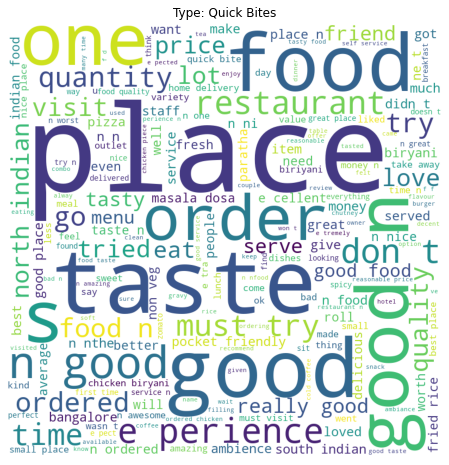

In [54]:
reviewwords(df_new,'Quick Bites')

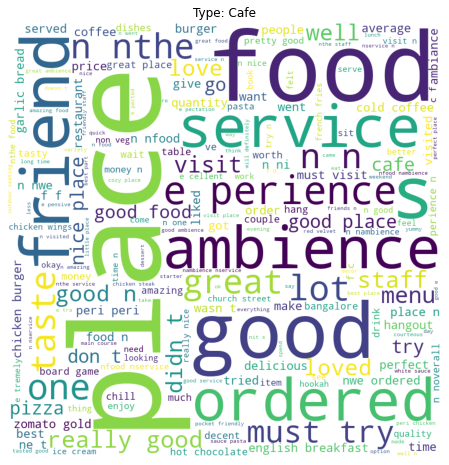

In [55]:
reviewwords(df_new,'Cafe')

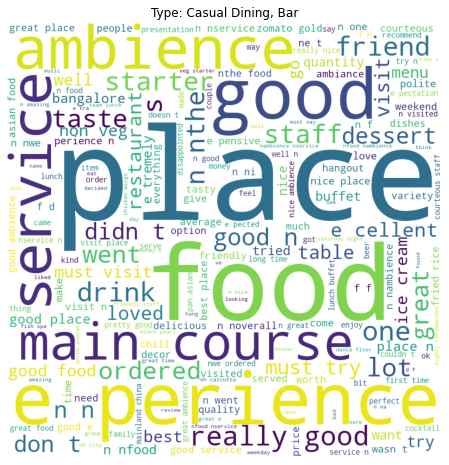

In [56]:
reviewwords(df_new,'Casual Dining, Bar')

В каждой категории заведений отзывы состоят из примерно одинаковых слов, т.е. их содержаниею плюс-минус похоже. 

Еще интересно посмотреть, в какой же категории больше хороших/плохих отзывов? 

In [26]:
sentiments=[]
for i in range(0,len(res)):
    analysis = TextBlob(res.loc[i,"reviews_list"])
    if analysis.sentiment.polarity > 0:
        sentiments.append("positive")
    elif analysis.sentiment.polarity == 0:
        sentiments.append("Neutral")
    else:
        sentiments.append("negative")
        

In [27]:
res["sentiments"]=sentiments
res.head(4)

address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   

  online_order book_table  rate  votes      location            rest_type  \
0          Yes        Yes   4.1    775  Banashankari        Casual Dining   
1          Yes         No   4.1    787  Banashankari        Casual Dining   
2          Yes         No   3.8    918  Banashankari  Cafe, Casual Dining   
3           No         No   3.7     88  Banashankari          Quick Bites   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   

                         cuisines  cost  \
0  North Indian, Mughlai, Chinese   800   
1     Chinese, North Indian, Thai   800   
2          Cafe, Mexican, Italian   800   
3      South Indian, North Indian   300   

                                        reviews_list menu_item    type  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []  Buffet   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []  Buffet   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []  Buffet   
3  [('Rated 4.0', "RATED\n  Great food and proper...        []  Buffet   

           city sentiments  
0  Banashankari   positive  
1  Banashankari   positive  
2  Banashankari   positive  
3  Banashankari   positive

In [73]:
type_sent = pd.pivot_table(pd.DataFrame(res.groupby(['type','sentiments'])['name'].count()), values=None, index=['type'], columns=['sentiments'], fill_value=0, aggfunc=np.sum)
type_sent


name                  
sentiments         Neutral negative positive
type                                        
Buffet                  15       20      835
Cafes                  161       65     1477
Delivery              3900     2648    19069
Desserts               657      141     2761
Dine-out              2804     1360    13398
Drinks & nightlife      43       12     1036
Pubs and bars           52        7      629

<AxesSubplot:xlabel='type'>

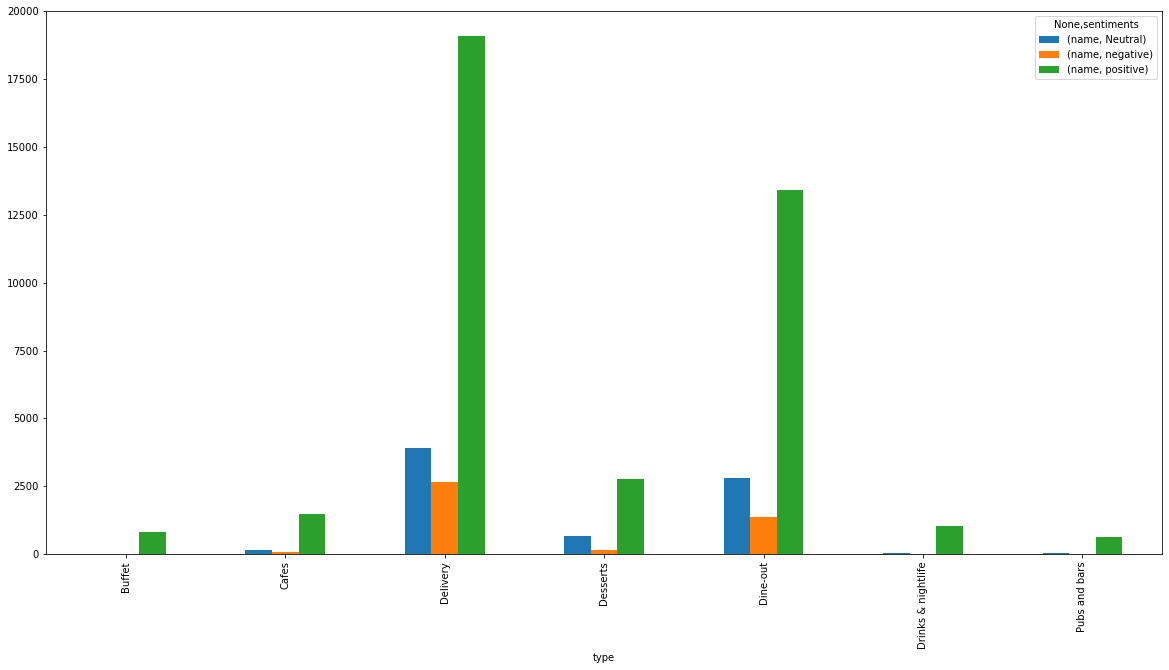

In [97]:
type_sent.plot(kind = 'bar', figsize = (20,10))

In [141]:
print('Menu_item missed values in all dataset: ',round((res[res.menu_item == '[]'].shape[0]/res.shape[0])*100,2),"%")

Menu_item missed values in all dataset:  76.44 %


На основании анализа выше сформируем датасет для рекоммендательной системы.
- address - включать не будем, поскольку (на основании проведенного выше анализа, в частности визуализации на карте) все основные данные по району содержатся в столбце location
- name - включаем
- online_order и book_table - закодируем 0 и 1
- rate и votes - включаем, поскольку на основании анализа, проведенного выше, можно сделать вывод, что есть какая-то взаимосвязь данных параметров с другими, например, с location или типом кухни, к тому же логично предлагать пользователю наиболее похожие заведения с сортировкой по большему рейтингу
- location - включаем, на основании анализа выше можно сделать вывод, что рекоммендация может зависеть и от местоположения. Также добавим в дальнейшем значения геолокации, чтобы учитывать расстояние между районами
- rest_type, type и cuisines - включаем, по проведенному анализу видно, что вероятнее данные категории помогут выявлять зависимости 
- cost - включаем, чтобы предлагать пользователю наиболее близкие к его платежным способностям заведения
- dish_liked - не используем, поскольку по визуализации основных слов в зависимости от классов нельзя однозначно сказать, к какому из типов заведений относятся данные блюда, а для каждого типа заведения наиболее часто  встречающиеся блюда плюс-минус одинаковы, к тому же в данном столбце пропущено более 50% значений
- menu_item - не используем, пропущена большая часть значений (76%)
- city - включать не будем, поскольку в нем не значения городов, а некоторые (только малая часть) повторяющееся названия районов (улиц) из столбца location

### Recommendation System

In [652]:
rest_recommend = res.drop(['address','dish_liked','menu_item','city','sentiments'],axis=1)

In [653]:
rest_recommend['online_order'] = rest_recommend['online_order'].replace({'Yes':1,'No':0})
rest_recommend['book_table'] = rest_recommend['book_table'].replace({'Yes':1,'No':0})

In [654]:
rest_recommend.head(3)

name  online_order  book_table  rate  votes      location  \
0            Jalsa             1           1   4.1    775  Banashankari   
1   Spice Elephant             1           0   4.1    787  Banashankari   
2  San Churro Cafe             1           0   3.8    918  Banashankari   

             rest_type                        cuisines  cost  \
0        Casual Dining  North Indian, Mughlai, Chinese   800   
1        Casual Dining     Chinese, North Indian, Thai   800   
2  Cafe, Casual Dining          Cafe, Mexican, Italian   800   

                                        reviews_list    type  
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...  Buffet  
1  [('Rated 4.0', 'RATED\n  Had been here for din...  Buffet  
2  [('Rated 3.0', "RATED\n  Ambience is not that ...  Buffet

Поработаем еще над reviews_list. Почистим от символов, цифр, стопслов. Оставим в данном столбце только топ-20 слов по частоте.

In [655]:
rest_recommend["reviews_list"] = rest_recommend["reviews_list"].str.lower()

def remove_punctuation(text):
    PUNCT_TO_REMOVE = string.punctuation
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_stopwords(text):
    STOPWORDS = set(stopwords.words('english'))
    STOPWORDS.add('rated')
    STOPWORDS.add('ratedn')
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_numbers(text):
    numbers_pattern = re.compile(r'[0-9]')
    return numbers_pattern.sub(r'', text)

def remove_space(text):
    return re.sub(" +", " ", text)

def remove_spec_char(text):
    return re.sub("xã", "", text)

rest_recommend["reviews_list"] = rest_recommend["reviews_list"].apply(lambda text: remove_punctuation(text))

rest_recommend["reviews_list"] = rest_recommend["reviews_list"].apply(lambda text: remove_stopwords(text))

rest_recommend["reviews_list"] = rest_recommend["reviews_list"].apply(lambda text: remove_urls(text))

rest_recommend["reviews_list"] = rest_recommend["reviews_list"].apply(lambda text: remove_numbers(text))

rest_recommend["reviews_list"] = rest_recommend["reviews_list"].apply(lambda text: remove_space(text))

rest_recommend["reviews_list"] = rest_recommend["reviews_list"].apply(lambda text: remove_spec_char(text))

rest_recommend.head()


name  online_order  book_table  rate  votes      location  \
0                  Jalsa             1           1   4.1    775  Banashankari   
1         Spice Elephant             1           0   4.1    787  Banashankari   
2        San Churro Cafe             1           0   3.8    918  Banashankari   
3  Addhuri Udupi Bhojana             0           0   3.7     88  Banashankari   
4          Grand Village             0           0   3.8    166  Basavanagudi   

             rest_type                        cuisines  cost  \
0        Casual Dining  North Indian, Mughlai, Chinese   800   
1        Casual Dining     Chinese, North Indian, Thai   800   
2  Cafe, Casual Dining          Cafe, Mexican, Italian   800   
3          Quick Bites      South Indian, North Indian   300   
4        Casual Dining        North Indian, Rajasthani   600   

                                        reviews_list    type  
0   beautiful place dine inthe interiors take bac...  Buffet  
1   dinner family turned good choose suitable age...  Buffet  
2   ambience good enough pocket friendly cafe qua...  Buffet  
3   great food proper karnataka style full meals ...  Buffet  
4   good restaurant neighbourhood buffet system p...  Buffet

In [637]:
def get_top_words(text, max_words):
    if text != [''] and text != [' ']:
        vec = CountVectorizer(stop_words='english')

        bag_of_words = vec.fit_transform(text)

        sum_words = bag_of_words.sum(axis=0)

        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

        top_words = words_freq[:max_words]

        words_list = []

        for i in range(len(top_words)):
            words_list.append(top_words[i][0])

        return " ".join([word for word in words_list])
    
    else:
        return('no reviews')

In [656]:
rest_recommend["reviews_list"] = rest_recommend["reviews_list"].apply(lambda text: get_top_words([text],20))
rest_recommend.head()

name  online_order  book_table  rate  votes      location  \
0                  Jalsa             1           1   4.1    775  Banashankari   
1         Spice Elephant             1           0   4.1    787  Banashankari   
2        San Churro Cafe             1           0   3.8    918  Banashankari   
3  Addhuri Udupi Bhojana             0           0   3.7     88  Banashankari   
4          Grand Village             0           0   3.8    166  Basavanagudi   

             rest_type                        cuisines  cost  \
0        Casual Dining  North Indian, Mughlai, Chinese   800   
1        Casual Dining     Chinese, North Indian, Thai   800   
2  Cafe, Casual Dining          Cafe, Mexican, Italian   800   
3          Quick Bites      South Indian, North Indian   300   
4        Casual Dining        North Indian, Rajasthani   600   

                                        reviews_list    type  
0  good food place buffet dish parking service li...  Buffet  
1  good place food really family try nice staff b...  Buffet  
2  place churros good cafe pizza chocolate ambien...  Buffet  
3  food south indian served place taste variety q...  Buffet  
4  good kulcha village restaurant neighbourhood b...  Buffet

In [657]:
rest_recommend['cuisines'] = rest_recommend['cuisines'].str.lower()


In [658]:
rest_recommend['rest_type'] = rest_recommend['rest_type'].str.lower()


In [659]:
rest_recommend.head()

name  online_order  book_table  rate  votes      location  \
0                  Jalsa             1           1   4.1    775  Banashankari   
1         Spice Elephant             1           0   4.1    787  Banashankari   
2        San Churro Cafe             1           0   3.8    918  Banashankari   
3  Addhuri Udupi Bhojana             0           0   3.7     88  Banashankari   
4          Grand Village             0           0   3.8    166  Basavanagudi   

             rest_type                        cuisines  cost  \
0        casual dining  north indian, mughlai, chinese   800   
1        casual dining     chinese, north indian, thai   800   
2  cafe, casual dining          cafe, mexican, italian   800   
3          quick bites      south indian, north indian   300   
4        casual dining        north indian, rajasthani   600   

                                        reviews_list    type  
0  good food place buffet dish parking service li...  Buffet  
1  good place food really family try nice staff b...  Buffet  
2  place churros good cafe pizza chocolate ambien...  Buffet  
3  food south indian served place taste variety q...  Buffet  
4  good kulcha village restaurant neighbourhood b...  Buffet

Добавим еще в таблицу доп.признак по геолокации (был вычислен ранее, когда выводилась heatmap):

In [660]:
rest_recommend = rest_recommend.merge(rest_count, how="left", left_on = 'location', right_on = 'Name')

In [661]:
rest_recommend = rest_recommend.drop(['Name','count','geo_loc'],axis=1)
rest_recommend.head()

name  online_order  book_table  rate  votes      location  \
0                  Jalsa             1           1   4.1    775  Banashankari   
1         Spice Elephant             1           0   4.1    787  Banashankari   
2        San Churro Cafe             1           0   3.8    918  Banashankari   
3  Addhuri Udupi Bhojana             0           0   3.7     88  Banashankari   
4          Grand Village             0           0   3.8    166  Basavanagudi   

             rest_type                        cuisines  cost  \
0        casual dining  north indian, mughlai, chinese   800   
1        casual dining     chinese, north indian, thai   800   
2  cafe, casual dining          cafe, mexican, italian   800   
3          quick bites      south indian, north indian   300   
4        casual dining        north indian, rajasthani   600   

                                        reviews_list    type        lat  \
0  good food place buffet dish parking service li...  Buffet  15.887678   
1  good place food really family try nice staff b...  Buffet  15.887678   
2  place churros good cafe pizza chocolate ambien...  Buffet  15.887678   
3  food south indian served place taste variety q...  Buffet  15.887678   
4  good kulcha village restaurant neighbourhood b...  Buffet  12.941726   

         lon  
0  75.704678  
1  75.704678  
2  75.704678  
3  75.704678  
4  77.575502

Посмотрим, в каком названии района есть пропущенные значения по геолокации. Если есть, то вставим эти значения вручную, поискав в интернете:

In [662]:
print('Пропущенные значения по геолокации: ', rest_recommend['lat'].isnull().sum(),". Район: " , rest_recommend[rest_recommend['lat'].isnull() == 1]['location'].unique()[0])

Пропущенные значения по геолокации:  32 . Район:  Rammurthy Nagar


In [663]:
rest_recommend['lat'] = rest_recommend['lat'].fillna(13.0184435)
rest_recommend['lon'] = rest_recommend['lon'].fillna(77.67812149999997)


In [664]:
df_for_results = rest_recommend.copy()
df_for_results = df_for_results.drop_duplicates(subset=['name'])
df_for_results = df_for_results.reset_index(drop=True)

In [665]:
df_for_model = rest_recommend.copy()
df_for_model = df_for_model.drop_duplicates(subset=['name'])
df_for_model = df_for_model.reset_index(drop=True)

In [666]:
df_for_model.head(3)

name  online_order  book_table  rate  votes      location  \
0            Jalsa             1           1   4.1    775  Banashankari   
1   Spice Elephant             1           0   4.1    787  Banashankari   
2  San Churro Cafe             1           0   3.8    918  Banashankari   

             rest_type                        cuisines  cost  \
0        casual dining  north indian, mughlai, chinese   800   
1        casual dining     chinese, north indian, thai   800   
2  cafe, casual dining          cafe, mexican, italian   800   

                                        reviews_list    type        lat  \
0  good food place buffet dish parking service li...  Buffet  15.887678   
1  good place food really family try nice staff b...  Buffet  15.887678   
2  place churros good cafe pizza chocolate ambien...  Buffet  15.887678   

         lon  
0  75.704678  
1  75.704678  
2  75.704678

In [667]:
def space_clean(x):
        return str.lower(x.replace(" ", ""))

def clean_data(x):
        return str.lower(x.replace(",", " "))
    
for feature in ['name','location','rest_type','cuisines','type']:
    df_for_model[feature] = df_for_model[feature].apply(space_clean)
    
for feature in ['name','location','rest_type','cuisines','type']:
    df_for_model[feature] = df_for_model[feature].apply(clean_data)
    
df_for_model['reviews_list'] = df_for_model['reviews_list'].apply(clean_data)
    
df_for_model.head()

name  online_order  book_table  rate  votes      location  \
0                jalsa             1           1   4.1    775  banashankari   
1        spiceelephant             1           0   4.1    787  banashankari   
2        sanchurrocafe             1           0   3.8    918  banashankari   
3  addhuriudupibhojana             0           0   3.7     88  banashankari   
4         grandvillage             0           0   3.8    166  basavanagudi   

           rest_type                     cuisines  cost  \
0       casualdining  northindian mughlai chinese   800   
1       casualdining     chinese northindian thai   800   
2  cafe casualdining         cafe mexican italian   800   
3         quickbites      southindian northindian   300   
4       casualdining       northindian rajasthani   600   

                                        reviews_list    type        lat  \
0  good food place buffet dish parking service li...  buffet  15.887678   
1  good place food really family try nice staff b...  buffet  15.887678   
2  place churros good cafe pizza chocolate ambien...  buffet  15.887678   
3  food south indian served place taste variety q...  buffet  15.887678   
4  good kulcha village restaurant neighbourhood b...  buffet  12.941726   

         lon  
0  75.704678  
1  75.704678  
2  75.704678  
3  75.704678  
4  77.575502

In [668]:
def create_all_features(x):
    return  x['location'] + ' ' +x['rest_type'] + ' ' +x['cuisines']+' '+ x['type']+' '+ x['reviews_list']

df_for_model['all_features'] = df_for_model.apply(create_all_features, axis=1)

df_for_model.head()


name  online_order  book_table  rate  votes      location  \
0                jalsa             1           1   4.1    775  banashankari   
1        spiceelephant             1           0   4.1    787  banashankari   
2        sanchurrocafe             1           0   3.8    918  banashankari   
3  addhuriudupibhojana             0           0   3.7     88  banashankari   
4         grandvillage             0           0   3.8    166  basavanagudi   

           rest_type                     cuisines  cost  \
0       casualdining  northindian mughlai chinese   800   
1       casualdining     chinese northindian thai   800   
2  cafe casualdining         cafe mexican italian   800   
3         quickbites      southindian northindian   300   
4       casualdining       northindian rajasthani   600   

                                        reviews_list    type        lat  \
0  good food place buffet dish parking service li...  buffet  15.887678   
1  good place food really family try nice staff b...  buffet  15.887678   
2  place churros good cafe pizza chocolate ambien...  buffet  15.887678   
3  food south indian served place taste variety q...  buffet  15.887678   
4  good kulcha village restaurant neighbourhood b...  buffet  12.941726   

         lon                                       all_features  
0  75.704678  banashankari casualdining northindian mughlai ...  
1  75.704678  banashankari casualdining chinese northindian ...  
2  75.704678  banashankari cafe casualdining cafe mexican it...  
3  75.704678  banashankari quickbites southindian northindia...  
4  77.575502  basavanagudi casualdining northindian rajastha...

In [669]:
extra_values = coo_matrix(df_for_model[['online_order','book_table','cost','lat','lon']])
w_normalized = normalize(extra_values, norm='l1', axis=1)

In [670]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_for_model['all_features'])
fin_matrix = hstack([count_matrix,w_normalized]).toarray()
cosine_sim_extra = cosine_similarity(fin_matrix, fin_matrix)


In [671]:
df_for_model = df_for_model.reset_index()
indices = pd.Series(df_for_model.index, index=df_for_model['name'])

In [672]:
def weighted_rating(x,m,C):
    v = x['votes']
    R = x['rate']
    return (v/(v+m) * R) + (m/(m+v) * C)

def recommendations(name, indices, cosine_sim):
    name=name.replace(' ','').lower()
    idx = indices[name]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:6]

    rest_indices = [i[0] for i in sim_scores]
    
    score = [i[1] for i in sim_scores]
    
    restaurants = df_for_model.iloc[rest_indices][['name', 'rate', 'votes']]
    restaurants['sim_score'] = score
    vote_counts = restaurants[restaurants['votes'].notnull()]['votes'].astype('int')
    vote_averages = restaurants[restaurants['rate'].notnull()]['rate'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.50)
    qualified = restaurants[(restaurants['votes'] >= m) & (restaurants['votes'].notnull()) & (restaurants['rate'].notnull())]
    qualified['votes'] = qualified['votes'].astype('int')
    qualified['rate'] = qualified['rate'].astype('int')
    qualified['wr'] = qualified.apply(lambda x: weighted_rating(x,m,C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    wr = qualified['wr']
    sim = qualified['sim_score']
    
    df_returned = pd.DataFrame(df_for_results.iloc[qualified.index]) 
    
    df_returned['weighted_rating'] = wr
    df_returned['sim_score'] = sim
    
    df_returned = df_returned.reset_index(drop=True)
    
    return df_returned 


In [673]:
name = 'Sugar Rush'
df_for_results[df_for_results.name == name]

name  online_order  book_table  rate  votes      location rest_type  \
66  Sugar Rush             0           0   3.8     39  Banashankari    bakery   

            cuisines  cost                                       reviews_list  \
66  bakery, desserts   300  cakes amazing cake cupcakes chocolate best goo...   

        type        lat        lon  
66  Delivery  15.887678  75.704678

In [674]:
recommendations(name, indices, cosine_sim_extra)

name  online_order  book_table  rate  votes    location  \
0        Creamyum             0           0   4.0     95  HBR Layout   
1       Cariocake             0           0   3.9     56    JP Nagar   
2  Cake Town Cafe             1           0   3.9     75   Bellandur   

                rest_type          cuisines  cost  \
0                delivery  bakery, desserts   300   
1                  bakery  bakery, desserts   350   
2  bakery, dessert parlor  bakery, desserts   500   

                                        reviews_list      type        lat  \
0  cake creamyum cakes ordered birthday order tas...  Delivery  13.035870   
1  cake cupcakes best cakes taste good variety am...  Delivery  12.265594   
2  cake cakes wheat ordered place healthy good ch...  Delivery  12.931032   

         lon  weighted_rating  sim_score  
0  77.632360         3.703311   0.596341  
1  76.646540         3.100000   0.616375  
2  77.678247         3.085496   0.606561

Построенная рекомендательная система работает на подходе поиска косинусного расстояния между двумя наблюдениям и последующего нахождения ближайшего наблюдения (ресторана) к заданному. При этом, рекомендательная система анализирует основную текстовую информацию о датасете (локация в виде текстового названия, типа ресторана, кухня ресторана), которая подается в систему через  CountVectorizer подход. Также подается список наиболее часто встречающихся слов в отзывах, чтобы посчитать похожесть и по этому признаку, поскольку, как правило, пользователи в отзывах пишут насколько хорош ресторан (good/great/bad etc.), а также добавляют то, что им понравилось, например, сервис или названия  блюд, что также можно учитывать как описание ресторана. Кроме этого, система учитывает похожесть таких параметров, как заказ онлайн, возможность брони стола, средний чек и геолокация (близость по широте и долготе). 

Затем значения сортируются по величине метрики - косинусного расстояния.

Для того, чтобы система предлагала пользователю только лучшие по рейтингу и количеству голосов из ближайших ресторанов, а не все подряд, происходит сортировка по наибольшим голосам и рейтингам, выводя метрику средневзвешенного рейтинга. 